# Trait Differentiation Between Domesticated and Wild Crops

**Objective:**
Determine which plant traits significantly differ between domesticated and wild crop accessions.

The **Crop Domestication Traits Database (CDTD)** is a comprehensive compilation of trait measurements derived from **79 peer-reviewed** publications reporting comparative studies of crop domestication. It includes **1,492 records** from **58 crop species**, covering a wide range of domestication-related traits under diverse environmental and experimental conditions worldwide. 

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.stats import mannwhitneyu 

import warnings
import math


## Load and Prepare the Data 

In [51]:
file_path = 'CropDomesticationTraitsDatabase.csv'
df = pd.read_csv(file_path)

# Keep only relevant columns
columns_to_keep = [
    'Dome_status',         # domestication status
    'Crop_name',           # common name of crop
    'Yield', 'SW',         # seed and yield traits
    'PH',                  # plant height
    'PLA', 'PSN'           # leaf area and seed number    
]
df = df[columns_to_keep]

# Define trait columns of interest
trait_columns = ['Yield', 'SW', 'PLA', 'PSN']

# Remove rows where any of these traits are missing
df = df.dropna(subset=trait_columns, how='all')

# Basic info
print("Dataset shape after filtering:", df.shape)
print(df['Dome_status'].value_counts())


Dataset shape after filtering: (615, 7)
Dome_status
wild          328
cultivated    287
Name: count, dtype: int64


In [52]:
df.head(200)

,Dome_status,Crop_name,Yield,SW,PH,PLA,PSN
56,cultivated,Barley,0.0405,NaN,NaN,NaN,NaN
57,cultivated,Barley,0.0580,NaN,NaN,NaN,NaN
58,cultivated,Barley,0.0574,NaN,NaN,NaN,NaN
59,cultivated,Barley,0.0481,NaN,NaN,NaN,NaN
60,cultivated,Barley,0.0398,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
267,wild,White clover,NaN,0.661,5.235,NaN,NaN
268,cultivated,Wheat,NaN,55.998,65.450,NaN,NaN
269,wild,Wheat,NaN,34.390,24.868,NaN,NaN
270,cultivated,Pea,NaN,1435.875,32.080,NaN,NaN


Limit dataset to only the top 5 most prevalent crops.

In [53]:
# Count occurrences of each crop
top_crops = df['Crop_name'].value_counts().head(5)


print("Top 5 most prevalent crops:")
print(top_crops)


Top 5 most prevalent crops:
Crop_name
Common bean    137
Wheat           93
Barley          53
Amaranth        43
Maize           35
Name: count, dtype: int64


In [54]:
# Filter dataframe to include only those crops
top_crops = df['Crop_name'].value_counts().head(5).index.tolist()
df = df[df['Crop_name'].isin(top_crops)]

# Basic info
print("Dataset shape after filtering:", df.shape)
print(df['Dome_status'].value_counts())

Dataset shape after filtering: (361, 7)
Dome_status
wild          205
cultivated    156
Name: count, dtype: int64


In [55]:
df.head(200)

,Dome_status,Crop_name,Yield,SW,PH,PLA,PSN
56,cultivated,Barley,0.0405,NaN,NaN,NaN,NaN
57,cultivated,Barley,0.0580,NaN,NaN,NaN,NaN
58,cultivated,Barley,0.0574,NaN,NaN,NaN,NaN
59,cultivated,Barley,0.0481,NaN,NaN,NaN,NaN
60,cultivated,Barley,0.0398,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
474,cultivated,Amaranth,NaN,NaN,14.5500,162.53,NaN
475,cultivated,Amaranth,NaN,NaN,20.1500,505.00,NaN
476,wild,Amaranth,NaN,NaN,16.5000,437.10,NaN
477,wild,Amaranth,NaN,NaN,27.6000,669.63,NaN


## Visual Exploratory Data Analysis 

### Heatmap of Missing Data

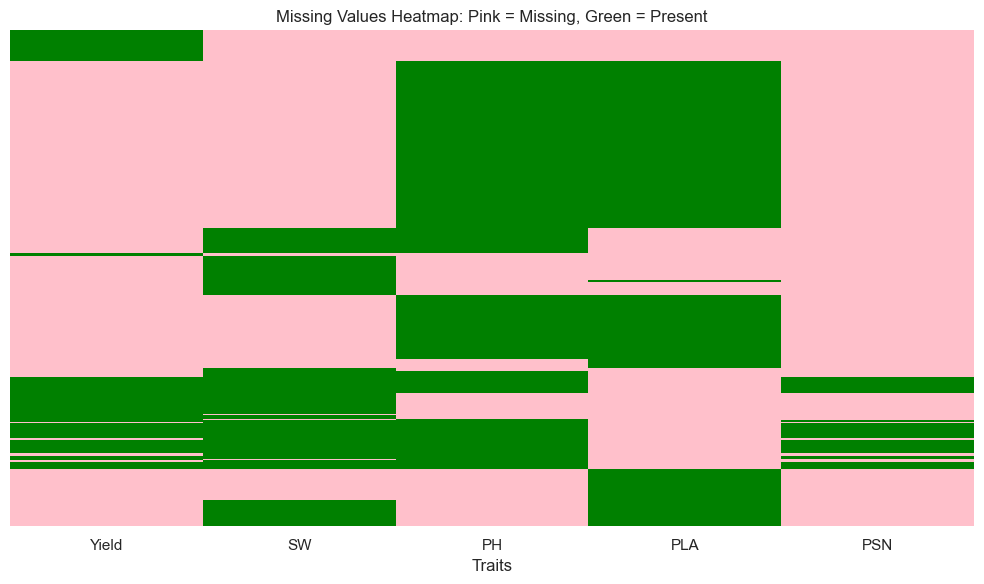

In [57]:
# Use only trait columns for visualization
trait_columns = ['Yield', 'SW', 'PH', 'PLA', 'PSN']

# Custom red-green colormap: red for NaN (True), green for not-NaN (False)
cmap = ListedColormap(['green', 'pink'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[trait_columns].isna(), cmap=cmap, cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap: Pink = Missing, Green = Present")
plt.xlabel("Traits")
plt.tight_layout()
plt.show()



In [60]:
# Count available records per trait, crop, and status
traits = ['Yield', 'SW', 'PH', 'PLA', 'PSN']
for trait in traits:
    print(f"\nTrait: {trait}")
    print(df.groupby(['Crop_name', 'Dome_status'])[trait].apply(lambda x: x.notna().sum()).unstack(fill_value=0))



Trait: Yield
Dome_status  cultivated  wild
Crop_name                    
Amaranth             19    12
Barley               16    16
Common bean           0     0
Maize                 1     1
Wheat                10    11

Trait: SW
Dome_status  cultivated  wild
Crop_name                    
Amaranth             21    13
Barley               12    12
Common bean           7     8
Maize                 4     4
Wheat                31    24

Trait: PH
Dome_status  cultivated  wild
Crop_name                    
Amaranth             26    17
Barley               12    11
Common bean          10   112
Maize                 4     4
Wheat                29    13

Trait: PLA
Dome_status  cultivated  wild
Crop_name                    
Amaranth              4     3
Barley                4     3
Common bean          10   112
Maize                23     2
Wheat                41    16

Trait: PSN
Dome_status  cultivated  wild
Crop_name                    
Amaranth             18    11
Barley    

### Boxplots for trait comparisons

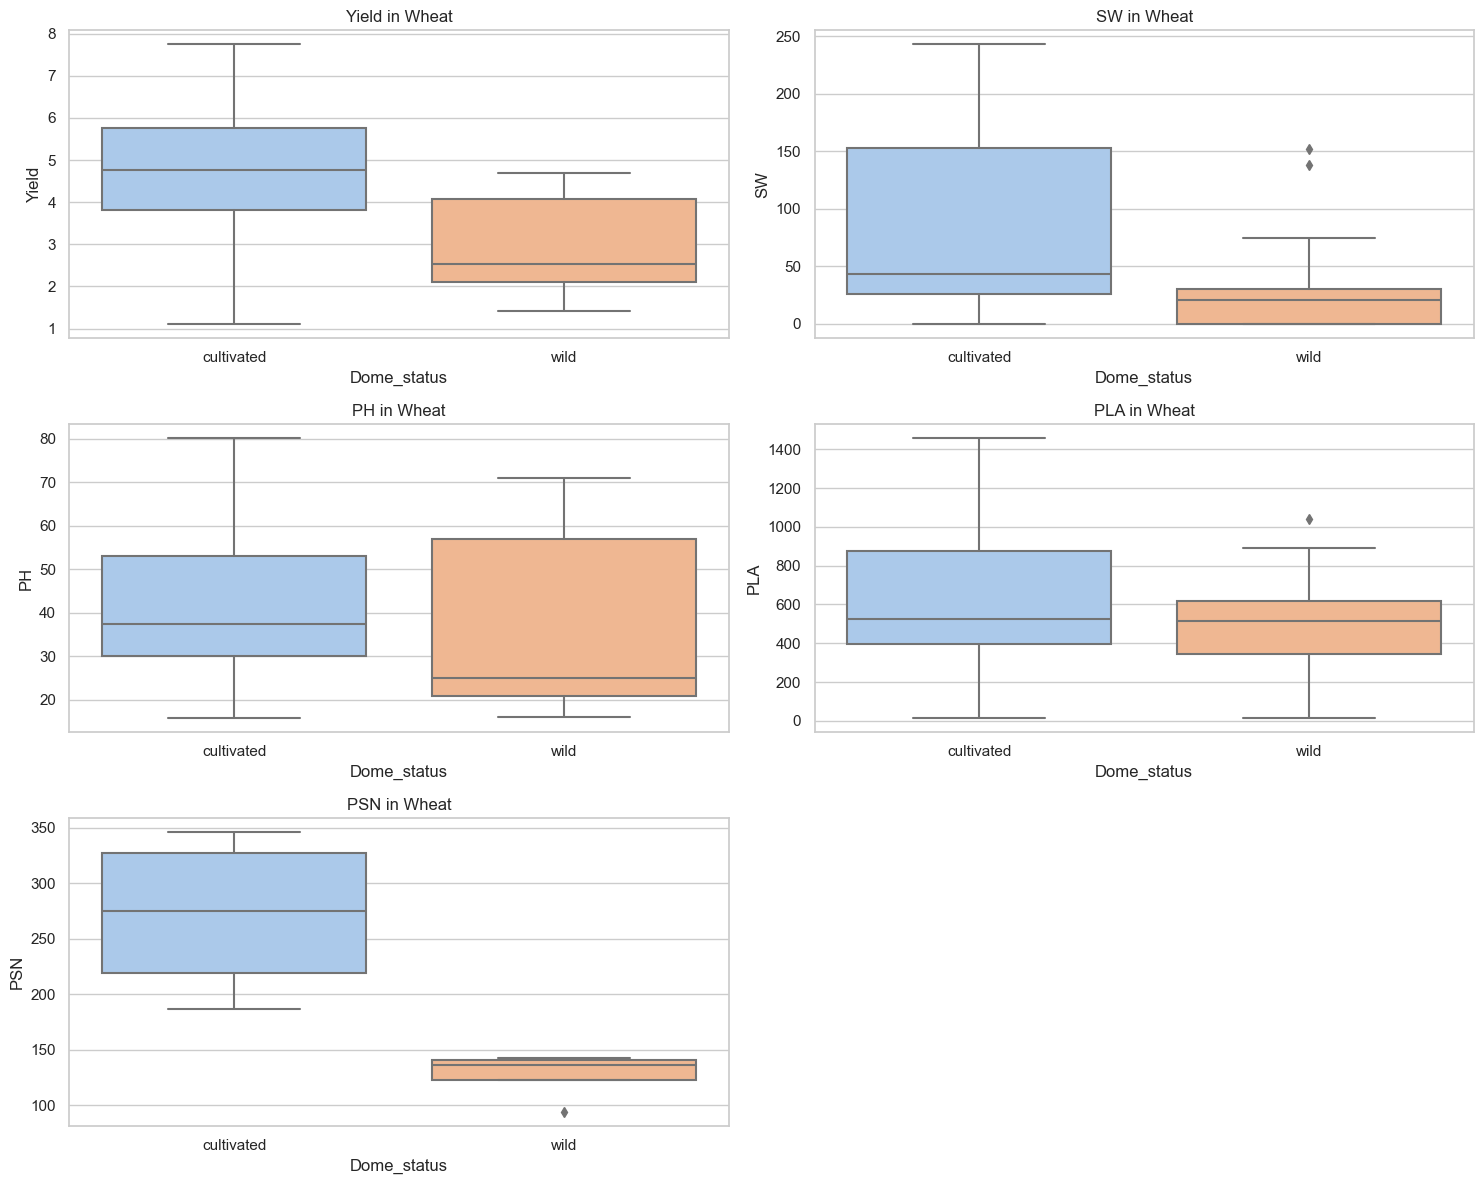

In [78]:
# Set Seaborn style
sns.set(style="whitegrid")

# Define the crop of interest
selected_crop = 'Wheat' 

# Filter to only that crop
df_crop = df[df['Crop_name'] == selected_crop].copy()

# Convert trait columns to numeric explicitly
traits = ['Yield', 'SW', 'PH', 'PLA', 'PSN']
for trait in traits:
    if trait in df_crop.columns:
        df_crop[trait] = pd.to_numeric(df_crop[trait], errors='coerce')

# Create subplots in 2-column layout
n_cols = 2
n_rows = math.ceil(len(traits) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Plot boxplots
for i, trait in enumerate(traits):
    if trait in df_crop.columns and pd.api.types.is_numeric_dtype(df_crop[trait]):
        sns.boxplot(x='Dome_status', y=trait, data=df_crop, palette='pastel', ax=axes[i])
        axes[i].set_title(f'{trait} in {selected_crop}')
    else:
        axes[i].set_visible(False)
        print(f"Skipping {trait}: not numeric or missing.")

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


### Histograms to Assess Distribution

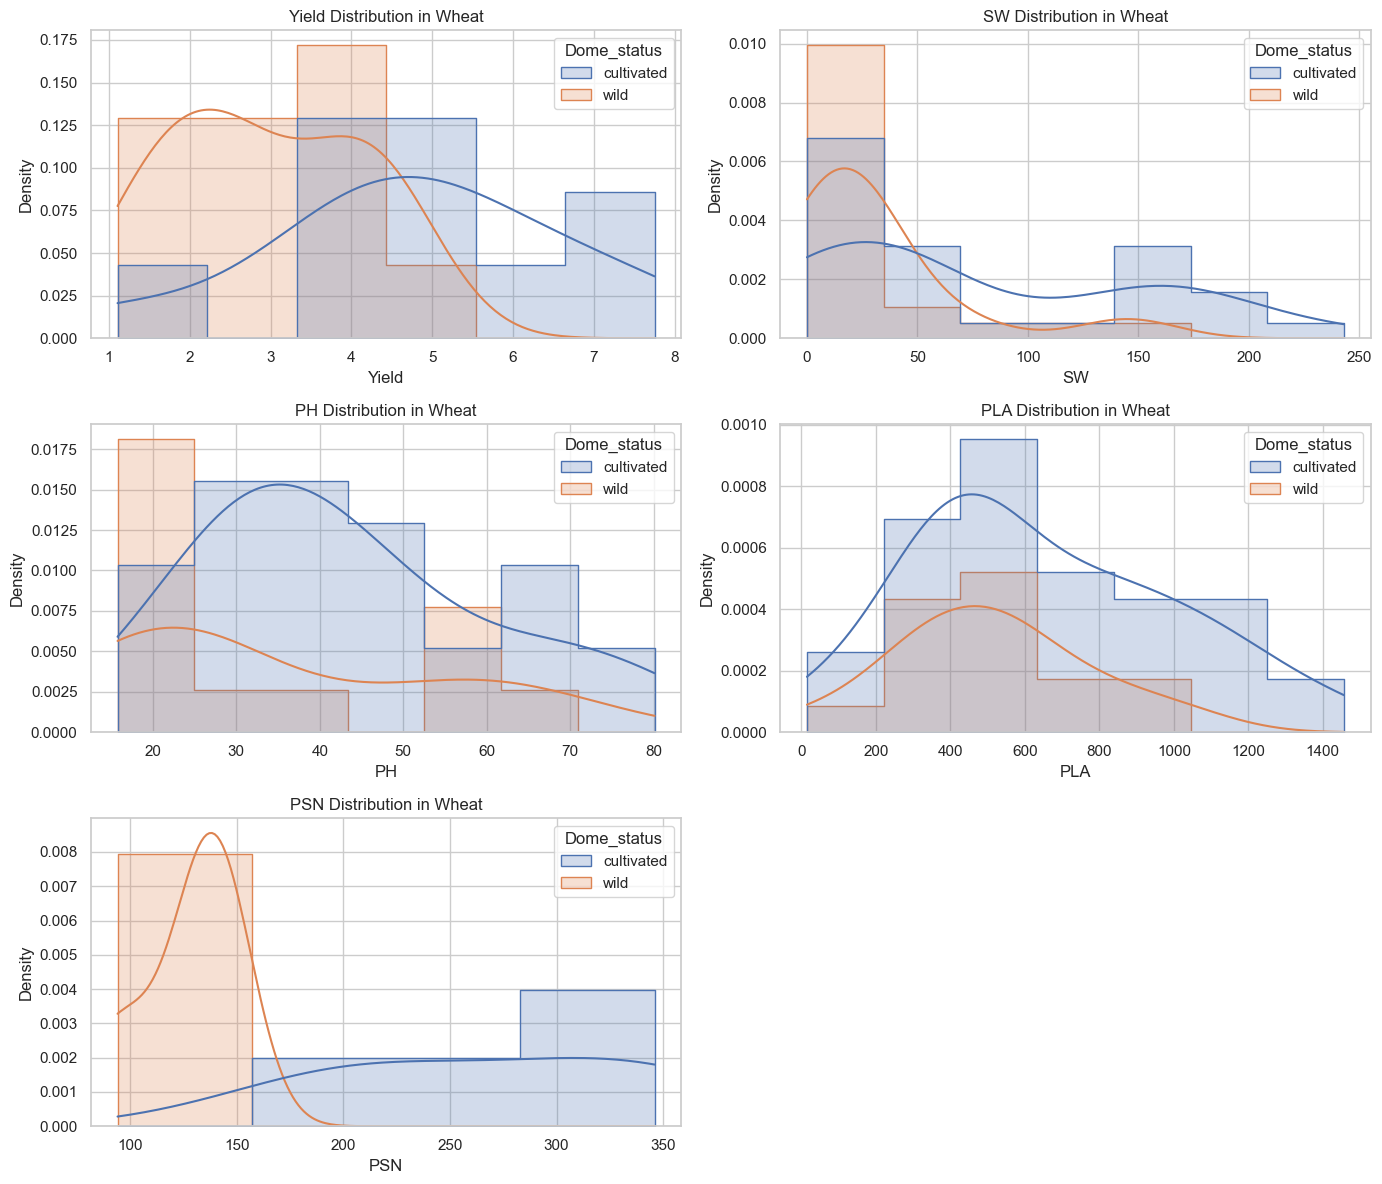

In [77]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set Seaborn style
sns.set(style="whitegrid")

# Choose the crop to analyze
selected_crop = 'Wheat'

# Filter the DataFrame to the selected crop
df_crop = df[df['Crop_name'] == selected_crop].copy()

# Convert trait columns to numeric explicitly
traits = ['Yield', 'SW', 'PH', 'PLA', 'PSN']
for trait in traits:
    if trait in df_crop.columns:
        df_crop[trait] = pd.to_numeric(df_crop[trait], errors='coerce')

# Prepare subplot grid
n_cols = 2
n_rows = math.ceil(len(traits) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

# Suppress user warnings from seaborn/matplotlib
warnings.filterwarnings("ignore", category=UserWarning)

# Plot histograms
for i, trait in enumerate(traits):
    if trait in df_crop.columns and pd.api.types.is_numeric_dtype(df_crop[trait]):
        sns.histplot(data=df_crop, x=trait, hue='Dome_status', kde=True,
                     element='step', stat='density', ax=axes[i])
        axes[i].set_title(f'{trait} Distribution in {selected_crop}')
    else:
        axes[i].set_visible(False)
        print(f"Skipping {trait}: not numeric or missing.")

# Hide extra axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


**Conclusion**: The histograms clearly show that trait distributions are not even close to normal.

## Mann–Whitney U test (non-parametric)

Compares medians between domesticated and wild samples without assuming normality.

In [72]:
# Select crop
selected_crop = 'Wheat'
df_crop = df[df['Crop_name'] == selected_crop].copy()

# Traits with valid data
valid_traits = ['Yield', 'SW', 'PH', 'PLA', 'PSN']

def cliffs_delta(x, y):
    """Calculate Cliff's Delta effect size between two numeric arrays."""
    x = np.array(x)
    y = np.array(y)
    n_x = len(x)
    n_y = len(y)
    more = sum(i > j for i in x for j in y)
    less = sum(i < j for i in x for j in y)
    return (more - less) / (n_x * n_y)

def interpret_cliffs_delta(delta):
    """Interpret Cliff's Delta based on thresholds."""
    abs_delta = abs(delta)
    if abs_delta < 0.147:
        return 'negligible'
    elif abs_delta < 0.33:
        return 'small'
    elif abs_delta < 0.474:
        return 'medium'
    else:
        return 'large'

results = []

for trait in valid_traits:
    # Clean conversion
    df_crop[trait] = pd.to_numeric(df_crop[trait], errors='coerce')

    group_dom = df_crop[df_crop['Dome_status'] == 'cultivated'][trait].dropna()
    group_wild = df_crop[df_crop['Dome_status'] == 'wild'][trait].dropna()

    if len(group_dom) >= 3 and len(group_wild) >= 3:
        # Statistical test
        stat, p = mannwhitneyu(group_dom, group_wild, alternative='two-sided')
        # Effect size
        delta = cliffs_delta(group_dom, group_wild)
        interpretation = interpret_cliffs_delta(delta)

        results.append({
            'Trait': trait,
            'U-statistic': stat,
            'p-value': p,
            'Significant (p < 0.05)': p < 0.05,
            "Cliff's Delta": round(delta, 3),
            'Effect Size Interpretation': interpretation
        })
    else:
        print(f"Skipping {trait}: not enough data in both groups.")


results_df = pd.DataFrame(results)

In [76]:
def highlight_significance(val):
    if val is True:
        return 'background-color: lightgreen; color: black'
    elif val is False:
        return 'background-color: lightpink; color: black'
    return ''

def highlight_effect_size(val):
    colors = {
        'negligible': '#e0f7fa',
        'small': '#b2ebf2',
        'medium': '#81d4fa',
        'large': '#4fc3f7'
    }
    color = colors.get(val, 'white')
    return f'background-color: {color}; color: black'

# Display table
results_df.style.format({
    'p-value': '{:.4f}',
    "Cliff's Delta": '{:.3f}'
}).applymap(highlight_significance, subset=['Significant (p < 0.05)']) \
  .applymap(highlight_effect_size, subset=['Effect Size Interpretation']) \
  .set_caption(f"Non-parametric Test Results for {selected_crop}")


,Trait,U-statistic,p-value,Significant (p < 0.05),Cliff's Delta,Effect Size Interpretation
0,Yield,87.000000,0.0265,True,0.582,large
1,SW,541.000000,0.0042,True,0.454,medium
2,PH,246.000000,0.1209,False,0.305,small
3,PLA,385.000000,0.2421,False,0.203,small
4,PSN,16.000000,0.0286,True,1.000,large


### Results

*Mann–Whitney U test* was conducted to compare trait values between cultivated and wild wheat accessions. The test was applied to five key domestication-related traits, and *Cliff’s Delta* was computed to estimate effect size.

- Significant differences were detected (p < 0.05) for three traits:

**Yield** (p = 0.0265, Cliff’s Delta = 0.582, large effect),

**Seed Weight (SW)** (p = 0.0042, Delta = 0.454, medium effect),

**Plant Seed Number (PSN)** (p = 0.0286, Delta = 1.000, large effect), indicating strong divergence between cultivated and wild forms.

- No statistically significant differences were found for:

**Plant Height (PH)** (p = 0.1209, Delta = 0.305, small effect),

**Plant Leaf Area (PLA)** (p = 0.2421, Delta = 0.203, small effect).

Overall, the results suggest that domestication in wheat is associated with significant increases in seed-related traits, particularly seed weight, seed number, and total yield, while vegetative traits such as height and leaf area exhibit weaker or non-significant divergence.